# **0.Preparation** 

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import matplotlib as mpl
import os
import cartopy
import cartopy.crs as ccrs
from datetime import datetime, timedelta

# **1.Dataset split**
Our whales migration dataset is from movebank and it has 50 individuals' routes. So out first step is to seperate each route and filler out some data.

In [0]:
# Load csv data 
filename =  'movebank_humpback.csv'
df = pd.read_csv(filename)

# To classify different routes to split and save files
grouped = df.groupby('tag-local-identifier')
ID_lst = []
output_dir = 'grouped_data'
for name,group in grouped:
    print(f'Now is working on NO.{name}')
    ID_lst.append(name)
    filename = os.path.join(output_dir,f'{name}.csv')
    group.to_csv(filename, index = False)

# ID_lst = [53348, 53359, 53376, 53383, 64235, 64238, 88717, 88718, 88723, 88725, 88728, 88729, 88730, 88732, 88733, 88734, 88735, 88736, 88737, 88738, 88741, 88742, 88743, 88744, 88745, 88746, 88747, 88748, 88750, 88751, 88752, 88753, 88754, 88755, 88756, 96385, 96386, 96390, 96395, 96398, 96401, 96403, 96404, 96412, 98100, 98109, 98114, 98129, 98138, 98139]

newID_lst = []
for i in ID_lst:
    operate_id = i
    operate_file = f'{operate_id}_sst.csv'
    df = pd.read_csv(operate_file)
    rows = df.shape[0]
    if rows > 30:                       #filter out files with records less than 30
        newID_lst.append(operate_id)
        print(operate_file, rows)


# **2.SST Data extraction**
As we have the position and time information at each record point for each route, we can now access the corresponding SST dataset online from NOAA and extract them. 

SST data can be viewed on [NOAA OI SST V2 High Resolution Dataset](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html)

Because each SST dataset we use contains all days of a year, so we first need to find the timeindex to get specific dimension.

In [4]:
# Find timeindex of nc file
def get_timeindex(a,b,c):
    if a == 2008:
        mon_lst = [31,29,31,30,31,30,31,31,30,31,30,31]
    else:
        mon_lst = [31,28,31,30,31,30,31,31,30,31,30,31]
    result = sum(mon_lst[:b-1]) + c-1 
    return result

In [0]:
# ---------- Below is Extract sst data function ----------- #
def extract_sst(filenumber):

# Extract time information
    filename = f'{filenumber}.csv'  # operating file
    df = pd.read_csv(filename)

    onetime_df = df.drop_duplicates(subset=['timestamp'],keep='first') #drop duplicate rows for simplifying
    time_df = onetime_df.copy()
    time_df['timestamp'] = pd.to_datetime(time_df['timestamp'])

    # Extract date information and save to new columns
    time_df['year'] = time_df['timestamp'].dt.year
    time_df['month'] = time_df['timestamp'].dt.month
    time_df['day'] = time_df['timestamp'].dt.day


    time_df = time_df.reset_index()
    time_df = time_df.drop(columns=['index'])
    length = time_df['year'].count()

    #Find nc file

    last_year = 0      # if they are in the same year, we don't need to open a new file (time_saving)
    last_month = 0
    last_day = 0
    timeindex = 0
    sst_lst = []
    for i in range(length):
        current_year = time_df['year'][i]
        current_month = time_df['month'][i]
        current_day = time_df['day'][i]

        #choose correct ncfile
        if current_year != last_year: 
            year = current_year
            filename = f'http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.{year}.nc'
            #print(filename)
            data = xr.open_dataset(filename)
            #data
            last_year = current_year
            lat = data['lat']
            lon = data['lon']
        else:
            pass

        # Get timeindex in file
        if current_month != last_month or current_day != last_day:
            timeindex = get_timeindex(current_year,current_month,current_day)
            last_month = current_month
            last_day = current_day
            sst = data['sst'][timeindex,:,:]
        else:
            pass

        print(f'Current progress: {i+1}/{length}')   # To see the progress of process

        #Find nearest point
        target_lat = time_df['location-lat'][i]
        target_long = time_df['location-long'][i]
        
        nearest_point = data.sel(lat=target_lat, lon=target_long, method='nearest')
        
        sst_at_point = nearest_point['sst'][timeindex].values
        sst_lst.append(float(sst_at_point))

    # Save sst data in a new column and to csv files
    time_df['sst'] = sst_lst
    time_df.to_csv(f'{filenumber}_sst.csv',index=False)

### Then we do a loop for each file

In [0]:
ID_lst = [88742, 88743, 88744, 88745, 88746, 88747, 88748, 88750, 88751, 88752, 88753, 88754, 88755, 88756, 96385, 96386, 96390, 96395, 96398, 96401, 96403, 96404, 96412, 98100, 98109, 98114, 98129, 98138, 98139]
for j in ID_lst:
    print(f'---------Now is extracting SST for No. {j}, Overall progress: {ID_lst.index(j)+1}/{len(ID_lst)}-------------')
    extract_sst(j)

# **3.Plot migration path and corresponding SST**
Since we already have the corresponding SST data, we can plot the migration path and related SST.

In [8]:
mpl.rc('font', family='serif') # Set ploting parameters

def SST_plot(operate_id):

    # Find operate csv files
    ID = operate_id
    filename = f'{ID}_sst.csv'
    df = pd.read_csv(filename,index_col=0)

    #Figure 1: Path Map
    fig1= plt.figure(figsize=(5,5))

    lon = list(df['location-long'])
    lat = list(df['location-lat'])

    map_proj = ccrs.PlateCarree() # Choose map projection
    ax1 = plt.axes(projection = map_proj) 
    ax1.coastlines()
    ax1.stock_img()
    extent = [120.4,179.9,-7,-70] # Set up the extent we want show
    ax1.set_extent(extent)
    ax1.set_title('Migration Path')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    gl1 = ax1.gridlines(linestyle='--',color='white',alpha=0.5,draw_labels=True)
    gl1.top_labels = False
    gl1.right_labels = False # Show the grid

    start_point_lon = lon[0]
    start_point_lat = lat[0]
    start_label = 'Start'
    end_point_lon = lon[-1]
    end_point_lat = lat[-1]
    end_label = 'End'           # Point out the start and end point

    ax1.scatter(lon,lat,color='yellow',s=20,marker='*',transform=ccrs.PlateCarree())
    ax1.scatter(start_point_lon,start_point_lat,s=50,marker='o',color='#2E8B57')
    ax1.scatter(end_point_lon,end_point_lat,s=50,marker='o',color='black')
    ax1.text(start_point_lon-3.5, start_point_lat+1, start_label, fontsize=12, transform=ccrs.PlateCarree())
    ax1.text(end_point_lon-2.5, end_point_lat-3, end_label, fontsize=12, transform=ccrs.PlateCarree())

    # Figure 2: Corresponding SST 
    fig2, ax2 = plt.subplots(figsize=(6,6))

    x = [i for i in range(df.shape[0])] #Record index 
    y = list(df['sst'])

    sc = plt.scatter(x,y,marker='o',s=15,color='green',alpha=0.8)
    ax2.grid(True,alpha=0.2,color='black',linestyle='--')
    ax2.set_ylabel('SST (°C)',fontsize = 'large')
    ax2.set_xlabel('Record',fontsize = 'large')
    ax2.set_title('Recorded SST',fontsize ='large')

    ax3 = ax2.twiny()
    time = list(df['timestamp']) #Add a timestamp 

    start_point = 0
    mid_point = int(len(time)/2)
    end_point = -1                      # Show the timestamp for three points

    ax3.scatter(time,y,alpha =0)
    ax3.set_xlabel('timestamp')
    ax3.set_xticks([time[start_point], time[mid_point], time[end_point]]) 

    #Conbine two figures together

    fig1.canvas.draw()
    fig2.canvas.draw()
    fig_combined, (new_ax1, new_ax2) = plt.subplots(1, 2, figsize=(12, 7))
    new_ax1.imshow(np.array(fig1.canvas.renderer.buffer_rgba()), aspect='auto')
    new_ax2.imshow(np.array(fig2.canvas.renderer.buffer_rgba()), aspect='auto')
    new_ax1.axis('off')
    new_ax2.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.001)
    fig_combined.suptitle(f'No.{ID}',fontsize=20,fontweight='bold')
    plt.show()
    plt.savefig(f'Path and SST_{ID}.png', dpi=300)
    plt.close()
    

### Then we do a loop for 44 filtered migration dataset

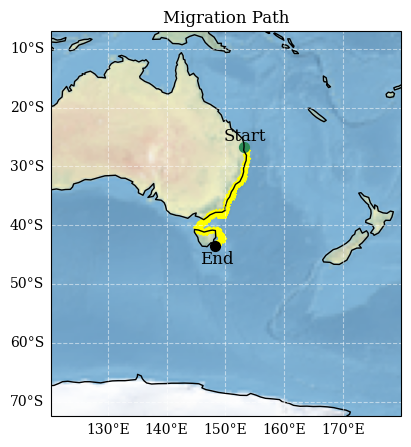

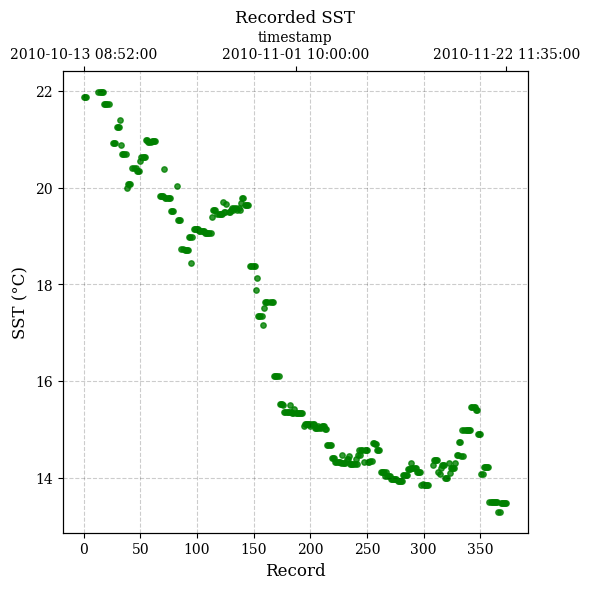

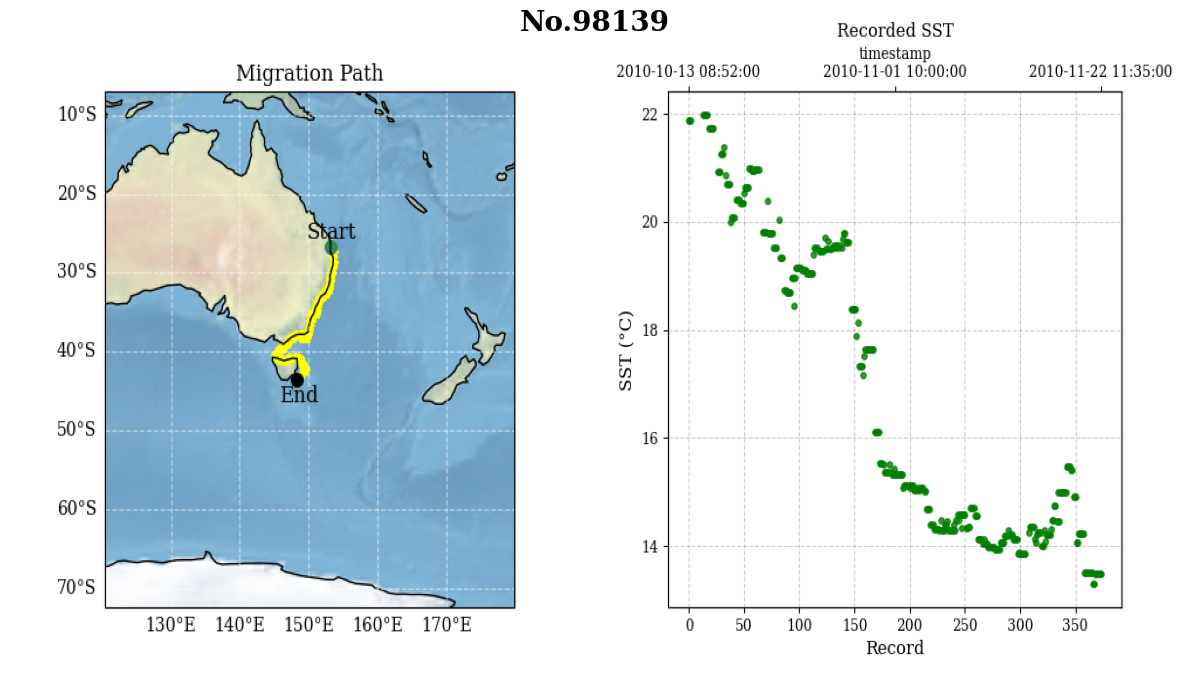

now is ploting No.98139 progress:0/1


In [9]:
newID_lst = [98139]
for id in newID_lst[:]:
    SST_plot(id)
    print(f'now is ploting No.{id}', f'progress:{newID_lst.index(id)}/{len(newID_lst)}')
    plt.close('all')

# **4.Recorded SST data plot**
We have observed what each migration path looks like and what are the corresponding SST. 

Now we want to see the recorded SST data in our dataset. What were the SST changes from our recorded time to the end of the dataset (2023).

The aim here is to make a speculation about possible change of migration path.

In [11]:
def recorded_sst_plot(ID):

    # Load csv data
    filename = f'{ID}_sst.csv'
    df = pd.read_csv(filename)
    file_length = df.shape[0]

    # Find 4 Points we use 
    # *Startpoint, *Endpoint, *Point with Maximum Latitude, *Point with Minimum Latitude

    # For the first two points, we want to illustrate that if whales migrate for warmth, the higher 
    # temperature at that point may lead to earlier appearence there,and vice versa.

    # For the last two points, we want to illustrate that if whales migrate for warmth, the lower 
    # temperature at that point may result in them not arriving at that latitude,and vice versa.
    
    operate_lst = []
    operate_lst.append(0)                                   # StartPoint
    operate_lst.append(file_length - 1)                     # EndPoint
    operate_lst.append(df['location-lat'].idxmax())         # Point with Maximum Latitude
    operate_lst.append(df['location-lat'].idxmin())         # Point with Minimum Latitude
    operate_name = ['StartPoint','EndPoint','MaxLat','MinLat']

    #Loop to operating for each point
    
    for j in range(len(operate_lst)):
        operate_index = operate_lst[j]
        point_name = operate_name[j]

        # Find the position information of that point
        target_lon = df['location-long'][operate_index]
        target_lat = df['location-lat'][operate_index]

        # Find time information, in other words, define our work time range
        start_year = df['year'][operate_index]
        end_year = 2024                # Set the end year here
        start_mon = df['month'][0]
        end_mon = df['month'][file_length - 1]
        start_day = df['day'][0]
        end_day = df['day'][file_length - 1] # Show sst data within recorded time period

        # Use data information get time range for nc file
        start_index = get_timeindex(start_year,start_mon,start_day)
        end_index = get_timeindex(start_year,end_mon,end_day)

        # Calculate step length (here we just show 15 time records for each point)
        # the reason here is that our SST data has three dimensions and Time is on the first one.
        # so it's impossible for us to plot every day data,otherwise it would be a really really slow and huge calculation
        # we set up a step goal here at 15, which means no matter how long the time range is, we just evenly select 15 points.

        if end_index < start_index:
            end_index = -1
            step_len = 15
        else:
            step_len = int((end_index - start_index)/15) # if time range less than 15, just set step length at 1.
            if step_len == 0 :
                step_len = 1
            else:
                pass
        
        # Create a figure
        fig = plt.figure(figsize=(7,4))

        #Create two lists for ploting label (the year on the right)
        ###Sequences are dependent###
        last_value = []
        year_index = []

        # List for plot 2
        average_sst = []

        #Load nc data
        for year in range(start_year,end_year):
            print(f'Now is ploting {ID},{point_name},{year}/{end_year-1}')
            filename = f'http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.{year}.nc'
            data = xr.open_dataset(filename)
            lat = list(data['lat'])
            lon = list(data['lon'])

            # Get point position index
            nearest_point = data.sel(lat=target_lat, lon=target_lon, method='nearest')
            lon_index = lon.index(float(nearest_point['lon']))
            lat_index = lat.index(float(nearest_point['lat']))
            
            #create x,y for ploting
            x = [i for i in range(start_index,end_index,step_len)]
            sst = data['sst'][start_index:end_index:step_len,lat_index,lon_index]
            year_sst = sst.values
            average_sst.append(sum(year_sst)/len(year_sst)) # calculate data for plot 2
            plt.plot(x,year_sst,marker='o', linestyle='--',alpha=0.45)

            # if we are ploting the last point, the sequence of label is based on the last value.
            if j == 1: 
                last_value.append(year_sst[-1])
                year_index.append(year)
            
            # if we are ploting the other points, the sequence of label is based on the first value
            else:
                last_value.append(year_sst[0])
                year_index.append(year)
        

        #Plot sequence of year (label)
        min_sst = min(last_value)
        max_sst = max(last_value)
        space = (max_sst - min_sst)/len(year_index)
        series = pd.Series(last_value, index=year_index)
        sorted_series = series.sort_values()
        label_year = sorted_series.index.to_list()
        ax = plt.gca()
        for i in range(len(label_year)):
            ax.text(1.06, 0.05 + i *0.06, f'{label_year[i]}', transform=ax.transAxes, fontsize=12, color='black', ha='center')
        ax.text(1.08, 0.05 + (i+1) *0.06, 'Sequence', transform=ax.transAxes, fontsize=10, color='black', ha='center')

        #Yearly average SST data
        average_series = pd.Series(average_sst,index=year_index)   
        #print(average_series)

        
        # Set up x ticks (we just want x to show the start date and end date)
        simplified_x = [start_index,x[-1]]
        simplified_labels = [f'{start_mon}-{start_day}', f'{end_mon}-{end_day}']
        
        # Plot 1
        plt.xticks(simplified_x, simplified_labels)
        plt.ylabel('SST (°C)',fontsize = 'large')
        plt.xlabel(f'Date (Step Length = {step_len}days)',fontsize = 'large')
        plt.title(f'Recorded SST at {point_name} for No.{ID}', fontsize=14)
        plt.tick_params(axis='both', labelsize=14)
        plt.tight_layout()
        plt.savefig(f'{ID}_R_{point_name}_SST.png',dpi=300)
        plt.show()
        plt.clf()
        plt.close()

        #Plot 2
        fig = plt.figure(figsize = (6,4))
        plt.plot(average_series.index.to_list(),average_series.tolist())
        #plt.xticks(average_series.index.to_list(),average_series.index.to_list(),color='black')
        plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5)) 
        plt.title(f'Recorded Annual Average SST at {point_name} for No.{ID}',fontsize=14)
        plt.xlabel('Year',fontsize=14)
        plt.ylabel('Average SST (°C)',fontsize = 'large')
        plt.grid(True,alpha=0.5)
        plt.savefig(f'{ID}_R&A_{point_name}_SST.png',dpi=300)
        plt.show()
        plt.clf()
        plt.close()
        



-------------------Now is on 98139--------------------
Now is ploting 98139,StartPoint,2010/2023
Now is ploting 98139,StartPoint,2011/2023
Now is ploting 98139,StartPoint,2012/2023
Now is ploting 98139,StartPoint,2013/2023
Now is ploting 98139,StartPoint,2014/2023
Now is ploting 98139,StartPoint,2015/2023
Now is ploting 98139,StartPoint,2016/2023
Now is ploting 98139,StartPoint,2017/2023
Now is ploting 98139,StartPoint,2018/2023
Now is ploting 98139,StartPoint,2019/2023
Now is ploting 98139,StartPoint,2020/2023
Now is ploting 98139,StartPoint,2021/2023
Now is ploting 98139,StartPoint,2022/2023
Now is ploting 98139,StartPoint,2023/2023
Now is ploting 98139,EndPoint,2010/2023
Now is ploting 98139,EndPoint,2011/2023
Now is ploting 98139,EndPoint,2012/2023
Now is ploting 98139,EndPoint,2013/2023
Now is ploting 98139,EndPoint,2014/2023
Now is ploting 98139,EndPoint,2015/2023
Now is ploting 98139,EndPoint,2016/2023
Now is ploting 98139,EndPoint,2017/2023
Now is ploting 98139,EndPoint,2018/20

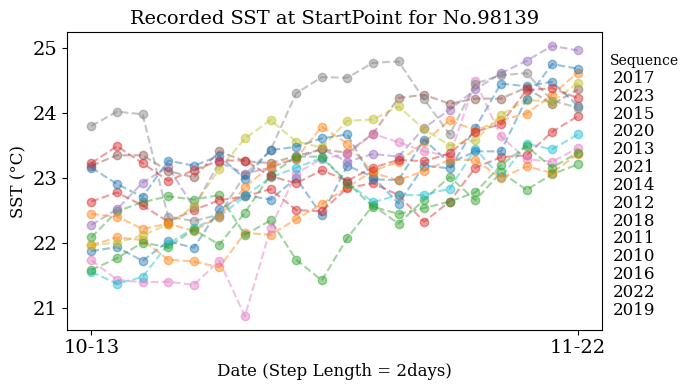

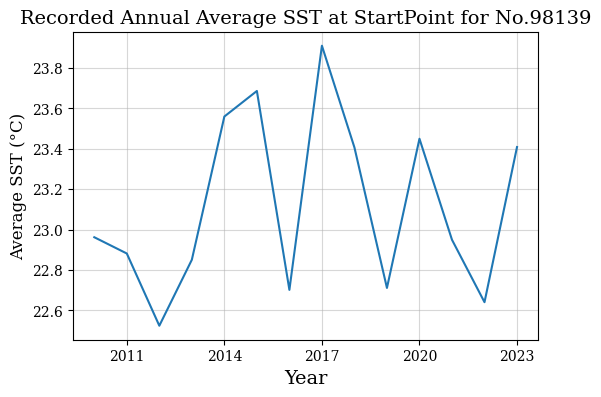

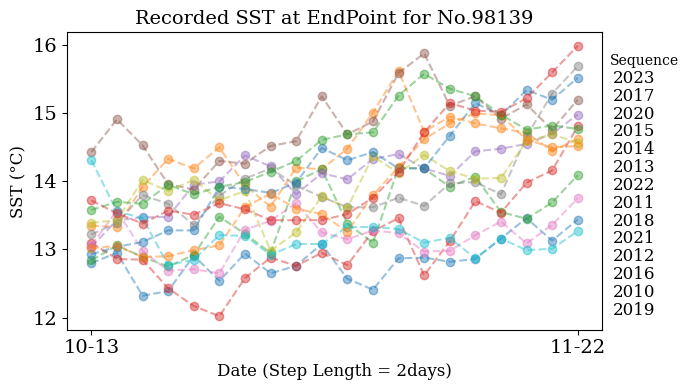

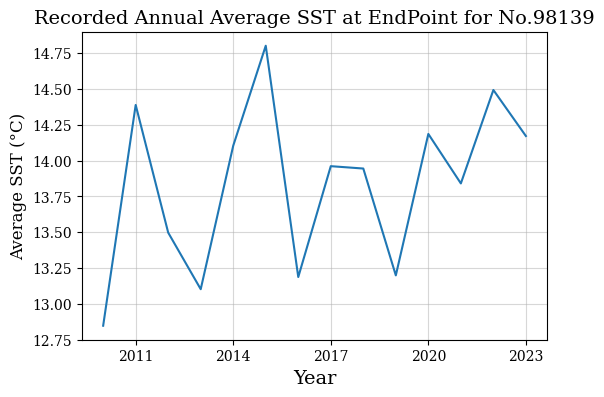

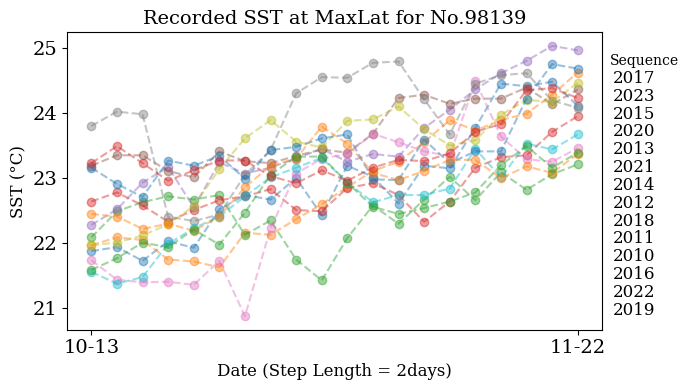

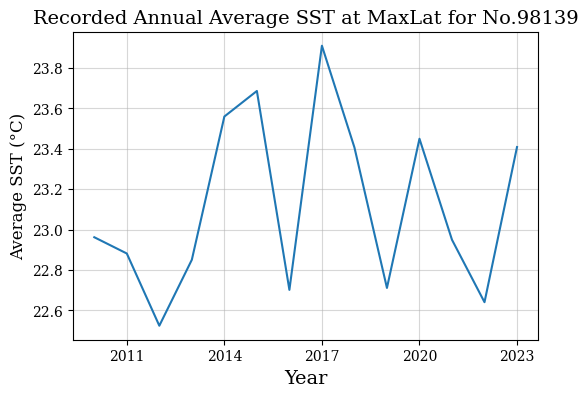

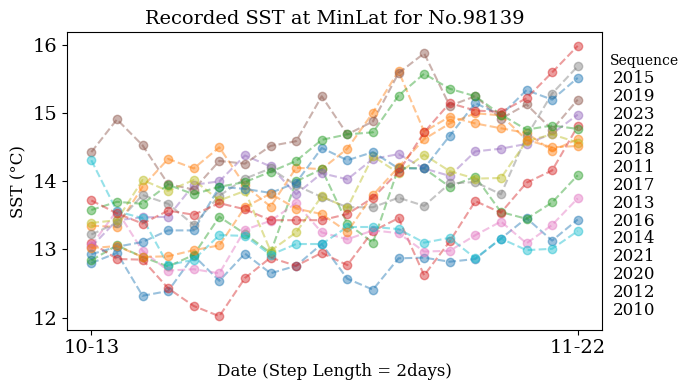

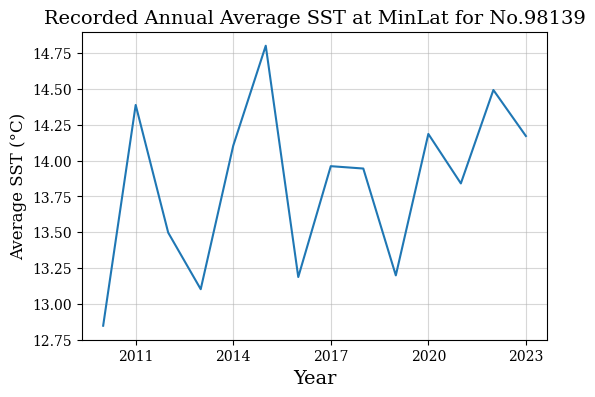

In [12]:
# We do a loop for what we want to operate
ID_lst = [98139]
for ID in ID_lst:
    print(f'-------------------Now is on {ID}--------------------')
    recorded_sst_plot(ID)